# CS492 전산학특강<인공지능 산업 및 스마트에너지>
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

## Week 6 - Advanced Models
### Deep Convolutional Generative Adversarial Network

---


## 1. What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)


<img src="https://miro.medium.com/max/3098/1*GVn3FkfSWT2gcEH3oYs6Uw.png" width="1000">

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

We will use the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)


## 2. Generative mdoel and GANs

### Taxonomy of deep generative models

<img src="https://www.researchgate.net/profile/Pablo_Sanchez_Martin/publication/331089295/figure/fig2/AS:726157746003968@1550140906069/Taxonomy-of-generative-models-based-on-maximum-likelihood-Extracted-from-11.ppm">

GANs은 maximum likelihood 기반의 generative model의 한 예이다. 또한 ML에 기반을 두고 있는 생성모델은 모델에 대한 확률변수를 구하는 방식에 따라 explicit density 방식과 implicit density 방식으로 나눠진다. Explicit density 방식은 데이터 분포로부터 그 데이터를 잘 설명하는 확률 분포를 모델의 학습 파라미터에 최적화하는 방식으로 찾아내는 방식으로, 앞서 배운 VAE 모델의 경우, 우리가 찾고자하는 확률 분포를 VI 등과 같은 approximation 기반으로 찾게된다. 

이와 달리 GAN 모델은 데이터의 분포로부터 모델의 확률 분포를 찾기보다는, Generator와 Disciminator라는 서로 경쟁하는 2개의 망을 이용하여 학습 데이터의 분포와 모델의 분포를 일치시키는 또는 근사시키는 작업을 수행한다. 즉, 이러한 과정을 통해 maximum likelihood를 추정하는 방식이다. (뒤에 loss 계산식을 보면 crossentropy를 활용하기 때문에, MLE로써 고려될 수 있다)


### GANs VS VAE
고차원을 갖는 데이터의 분포로부토 MLE를 통하여 직접 확률 분포를 추정하는 것은 일반적으로 계산이 매우 어렵거나 불가능하다. 
이에 대한 해결책으로 상대적으로 저차원이면서 단순한 구조를 갖는 어떤 입력으로부터 학습 데이터의 분포로 변형할 수 있는 방법을 사용할 수 있다. 특히 이러한 접근법에 학습 파라미터를 갖는 딥러닝과 같은 방법을 적용하여 최적화 기반으로 분포의 모수를 추정하는 방식으로 응용할 수 있다. 

VAE는 이러한 방식을 적용하기 위해 입력 데이터들에 대한 압축된 representation으로 latent variable z를 두고, 데이터 분포를 잘 반영한 z 변수로부터 이미지를 생성하게 된다. 
GAN의 경우, VAE에서의 z 변수를 정규분포의 확률변수, 즉 random noise로 두고 이를 입력으로하여 타겟 생성을 하게되며, 이러한 생성 모델을 잘 학습시켜서(또는 학습시킬수 있는 방법을 찾아서) 원하는 분포를 갖는 데이터를 생성하게된다. 이러한 접근법의 장점은 학습된 생성 모델은 입력의 random noise 값을 바꾸면 다른 데이터를 생성하는 것도 충분히 추론할 수 있게 된다. 

<img src="https://lilianweng.github.io/lil-log/assets/images/three-generative-models.png" width="700">



### Architecture of GANs 
 
<img src="https://t1.daumcdn.net/cfile/tistory/992D153A5C8CA96B21">


위 그림처럼 미분가능한 두개의 모델이 존재하는 구조이며, 각각 Generator / Discriminator로 불림.
- Discriminator: 실제 학습 데이터와 generator를 거쳐 만들어진 가짜 데이터를 이용하여 학습하며, 실제 샘플이 진짜인지 가짜인지 구별하는 역할
- Generator: Discriminator를 속일 수 있을 정도로 진짜와 가짜가 구별이 불가능한 수준의 가짜 데이터를 만드는 것이 목적 

즉, Discriminator는 입력으로 들어온 진짜, 가짜 데이터를 잘 판별하는 방향으로, generator는 discriminator를 잘 속이는 방향으로 학습하다보면, 
최종적으로 generator는 진짜인지 가짜인지 구분이 힘든 수준의 데이터를 만들 수 있게되고, discriminator 역시 분별 능력이 점차 개선되어 정교한 가짜 데이터를 찾아 낼 수 있게 된다. 

### Training process of the GANs (2 player minimax game)

GAN의 학습 방법은 다음과 같은 2단계로 이루어진다. 
 
![gan_training_process_1](images/gan_training_process_1.PNG)

1. 먼저, geneator를 고정시키고 discriminator를 학습시키는 것으로, discriminator는 어느 것이 진짜이고 어느 것이 가짜인지 알고 있기 때문에 기존에  판별 문제와 동일하게 학습 진행. 



![gan_training_process_2](images/gan_training_process_2.PNG)

2. 이번에는 discriminator를 고정시키고 generator를 학습시키는 과정으로, generator의 목적은 discriminator를 속이는 것이기 때문에 discriminator가 진짜로 착각할 수 있는 방향으로 학습 진행. 


이러한 과정을 반복적으로 수행하다 보면, discriminator와 generator가 발전을 거듭하여 평형상태에 도달하게 된다. 

<img src="https://1.bp.blogspot.com/-_ZpVHCkqwJI/WHjwzlgki8I/AAAAAAAABKk/e3xQukjtHBoxoQyLA7Fn-GhL7t8mgBFMwCK4B/s640/%25EA%25B7%25B8%25EB%25A6%25BC5.PNG">

 - 검은 점선: 학습 데이터 분포 ($P_{data}(X)$)
 - 녹색 실선: Generator에서 생성되는 데이터 분포, 즉 모델 분포 ($P_{model}(X)$)
 - 파란 점선: Discriminator의 출력 
 - 아래 선: $x=G(z)$의 mapping
 
 위 그림의 (a)를 보면, GAN 학습 초기 상태로 실제 데이터 분포와 모델 분포가 다르기 때문에 discriminator의 출력이 흔들리기도 하고 부분적으로만 정확하다가, 점차 학습이 진행하면서((b)->(c)) 모델 분포와 학습 데이터 분포가 점점 근사해짐. (d)에서는 두 분포가 정확하게 일치하면서 discriminator가 최적의 평형 상태인 $\frac{1}{2}$에 도달하게 된다. (discriminator가 진짜와 가짜를 전혀 구별 못하는 상태)
 

#### 2 player minimax game 

앞서 말한것처럼 GAN 모델은 2개의 신경망이 서로 적대적으로 동작하면서 학습된다. 
Discriminator는 입력 데이터가 진짜이면 1을 출력하고 가짜이면 0을 출력하며, 최대한 그럴듯한 가짜까지도 구별해낼 수 있어야 하며, generator는 discriminator를 속이는 방향으로, 즉 generator에서 만들어진 데이터가 discriminator에서 1이 되도록 학습 해야 한다. 

<img src="https://2.bp.blogspot.com/-2AA2ws2s6xc/WHjzFO5zBbI/AAAAAAAABKw/g91OEkkxPHYKPTsfKYC5yzXn3CmH6gi_ACK4B/s400/%25EA%25B7%25B8%25EB%25A6%25BC6.PNG" width="750">

**Objectrive function of GAN: $\min_G \max_D V(D,G) = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$**

**- Discriminator D:** 진짜와 가짜에 대한 구별을 잘하는 방향으로 학습 

-->$\max_D = \mathbb{E}_{x\sim p_{data}~(x)}[log D(x)] + \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$

**- Generator G:** D를 속일 수 있을 정도록 진짜 같은 가짜를 만드는 방향으로 학습 

-->$\min_G = \mathbb{E}_{z\sim p_x(z)}[log(1-D(G(z)))]$

Generator G의 경우, $1-D(G(z))$를 최소화 시키는데, 학습 초기에 G가 진짜같은 가짜 이미지를 만들어낼 능력이 없기 때문에 D가 쉽게 가짜를 구별해낸다. 이에 따라 gradient 값이 작아지기 때문에 학습이 잘 되지 않는 문제가 발생.

이를 해결하기 위해 $1-D(G(z))$를 최소화하는 대신 $D(G(z))$를 최대화하도록 바꾸어 학습한다. 

![modified_g_loss](images/modified_g_loss.PNG)


objective function에 대한 증명 참고: https://mc.ai/understanding-deep-learning-generative-adversarial-networks/

## 3. DCGAN 

### GAN의 불안정성
Original GAN은 MNIST 같은 단순한 이미지는 잘 생성하지만, CIFAR-10과 같은 복잡한 이미지에 대해서 잘 생성하지 못한다는 구조적인 문제가 존재.
이러한 문제를 해결하기 위해, CNN을 적용하고 다양한 실험을 통해 최적이라고 생각되는 구조를 찾아냄 -> DCGAN

![original_gan_example](images/original_gan_example.PNG)

또한 입력 데이터로 사용하는 input noise z에 대한 의미를 발견하여, generator의 입력으로 들어가는 z값이 바뀌면 생성되는 이미지가 변하게되고 이러한 변화가 vector arithmetic 개념이 적용된다는 사실을 찾아냄. 

- Word2vec에서의 vector arithmetic 예: KING - MAN + WOMAN = QUEEN 

- DCGAN에서의 vector arithmetic 예
<img src="https://4.bp.blogspot.com/-0rilHKMWwTQ/WKFnwwv5QUI/AAAAAAAABRc/jDewod7JSikDgY5Xn957yPNzpCy4ZXmhwCK4B/s1600/dcgan-vector-arithmatic.PNG">

### DCGAN의 구조적 특징
CNN을 GAN에 적용하여 최적의 결과를 찾기 위해 다음과 같은 5가지 방법 적용.
- 미분불가능한 Max-pooling layer를 없애고, strided convolution, fractionally-strided convolution 등을 사용하여 feature map의 크기 조절
- Batch normalization 적용
- Fully connected hidden layer 제거
- Generator 출력단의 activation function으로 Tanh 사용, 나머지 레이어는 ReLU 사용
- Discriminator의 activation function으로 LeakyReLU 사용

DCGAN generator 구조:

![dcgan_genenrator](images/dcgan_genenrator.PNG)


DCGAN discriminator 구조:

![dcgan_discriminator](images/dcgan_discriminator.PNG)

## Implementation of DCGAN

### Import TensorFlow and other libraries

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [5]:
# To generate GIFs
!pip install imageio

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

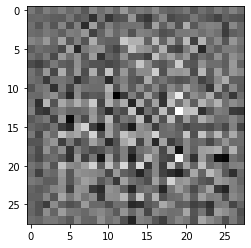

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image) # input the generated(fake) image to discriminator
print (decision)

tf.Tensor([[-0.00350478]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    # D tries to make D(x) near 1 (for real data)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    
    # D tries to make D(G(z)) near 0 (for fake data)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    # G tries to make D(G(z)) near 1 
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)

**Generate and save images**


In [23]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('generated_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

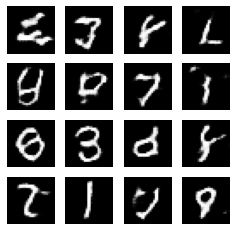

In [24]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [26]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

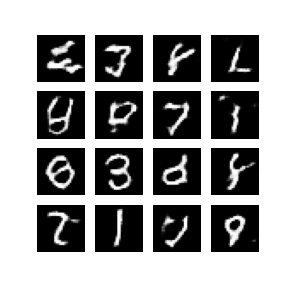

In [27]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('generated_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)
        
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
